# Análisis y Predicción del mercado inmobiliario

***Adrian Dumitru Chitic***

* ### Introducción
En este proyecto se aplica tecnicas de minería de datos para el análisis del mercado inmobiliario con el objetivo de predecir el precio de las viviendas en función de sus características

### Carga inicial de los datos
Cargamos los archivos test y train conseguidos desde la plataforma Kaggle, usaremos pandas para trabajar en el formato Dataframe

In [15]:
# Cargamos las librerías básicas
import pandas as pd
import numpy as np

# Cargamos los datasets de entrenamiento y testeo
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Tamaño y tipos de datos
Comprobamos las variables de los dataset y los tipos de datos mas relevantes

In [17]:
# Dimensiones del dataset
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Tipos de datos
train_df.dtypes.value_counts()

Train shape: (1460, 81)
Test shape: (1459, 80)


object     43
int64      35
float64     3
Name: count, dtype: int64

### Identificación de columnas con valores faltantes

In [19]:
# Revisar cuántos valores nulos hay por columna en train
missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Mostramos las primeras 15 columnas con más nulos
missing.head(15)


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
dtype: int64

### Limpieza de celdas con valores faltantes

In [21]:
cols_fill_none = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure'
]
for col in cols_fill_none:
    train_df[col] = train_df[col].fillna('None')

# 2. Rellenamos variables numéricas con 0 cuando el valor nulo indica que la característica no existe
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(0)

# 3. Imputamos LotFrontage con la mediana de su barrio (Neighborhood)
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# 4. Verificamos que no queden valores nulos tras la imputación
missing_after = train_df.isnull().sum()
missing_after = missing_after[missing_after > 0]

print("Columnas aún con nulos tras limpieza:", missing_after)

Columnas aún con nulos tras limpieza: MasVnrArea     8
BsmtQual      37
BsmtCond      37
Electrical     1
dtype: int64


In [22]:
# Rellenamos MasVnrArea con 0 si no hay mampostería
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)

# Rellenamos BsmtQual y BsmtCond con 'None'
train_df['BsmtQual'] = train_df['BsmtQual'].fillna('None')
train_df['BsmtCond'] = train_df['BsmtCond'].fillna('None')

# Rellenamos Electrical con el valor más frecuente (moda)
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])

# Verificación final
print("¿Quedan nulos?", train_df.isnull().sum().sum())


¿Quedan nulos? 0


### Análisis de la variable "SalePrice" que es nuestra variable que refleja el precio de la vivienda

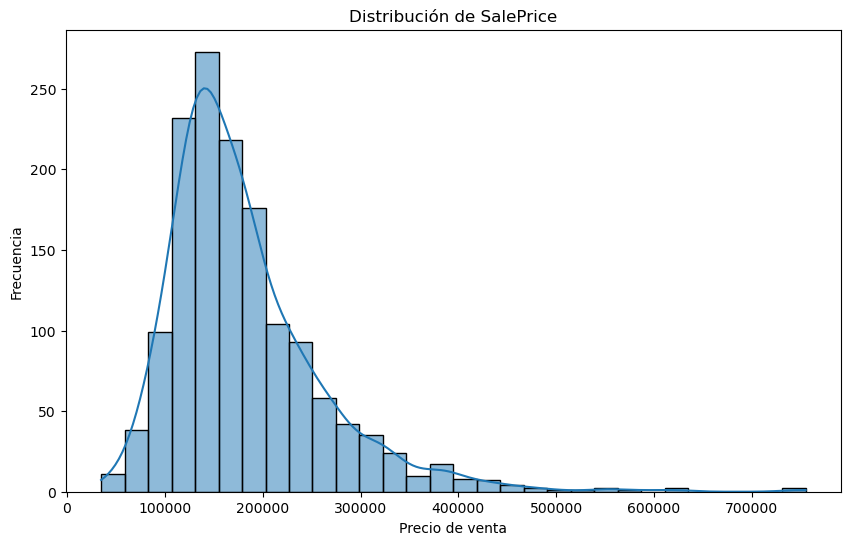

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de la variable objetivo
plt.figure(figsize=(10,6))
sns.histplot(train_df['SalePrice'], kde=True, bins=30)
plt.title('Distribución de SalePrice')
plt.xlabel('Precio de venta')
plt.ylabel('Frecuencia')
plt.show()

# Estadísticas básicas
print(train_df['SalePrice'].describe())


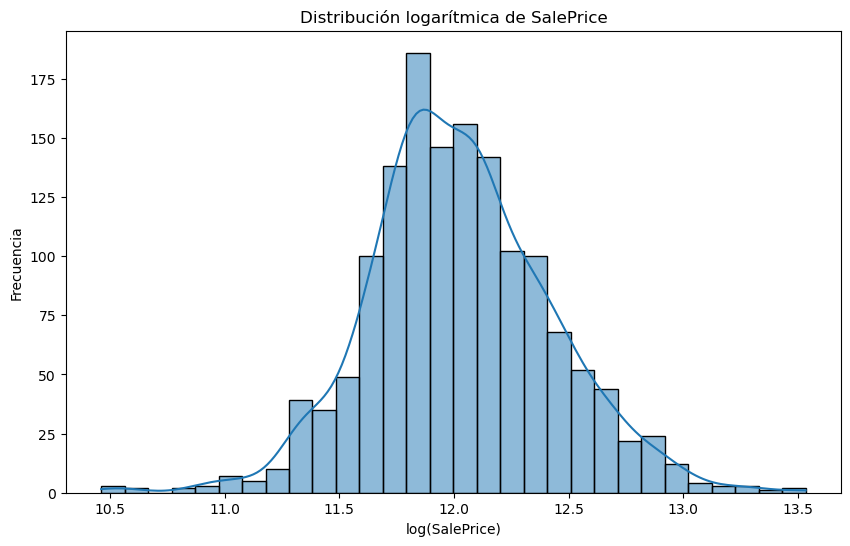

In [25]:
# Transformación logarítmica de la variable objetivo
train_df['LogSalePrice'] = np.log1p(train_df['SalePrice'])

# Visualizamos la distribución logarítmica
plt.figure(figsize=(10,6))
sns.histplot(train_df['LogSalePrice'], kde=True, bins=30)
plt.title('Distribución logarítmica de SalePrice')
plt.xlabel('log(SalePrice)')
plt.ylabel('Frecuencia')
plt.show()


### Correlaciones
Calculamos la correlación de las variables con "LogSalePrice" para identificar cuales son las que mas tienen mas impacto, viendo cuales son las claves

Top 10 variables más correlacionadas con LogSalePrice:
SalePrice       0.948374
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
Name: LogSalePrice, dtype: float64


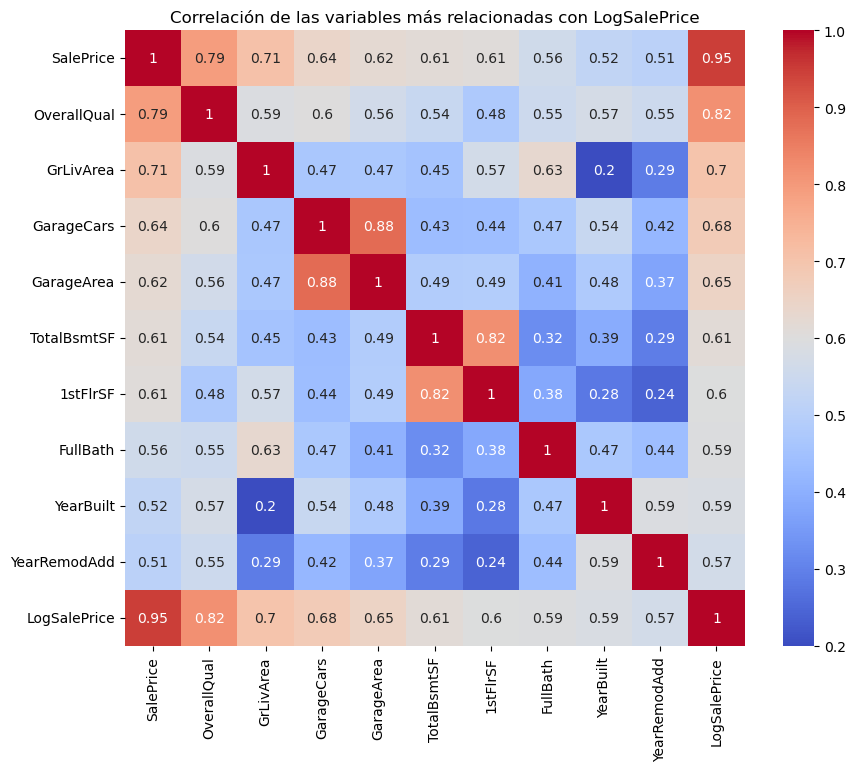

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filtramos las columnas numéricas
numeric_features = train_df.select_dtypes(include=[np.number])

# 2. Correlación con LogSalePrice
correlation_matrix = numeric_features.corr()
correlations = correlation_matrix['LogSalePrice'].sort_values(ascending=False)

# 3. Top 10 variables más correlacionadas (excluyendo LogSalePrice)
top_corr = correlations.drop('LogSalePrice').head(10)
print("Top 10 variables más correlacionadas con LogSalePrice:")
print(top_corr)

# 4. Visualización en heatmap
top_features = top_corr.index.tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[top_features + ['LogSalePrice']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación de las variables más relacionadas con LogSalePrice')
plt.show()


### Entrenamiento del modelo
Vamos a entrenar el modelo con las variables mas correlacionadas y evaluamos el rendimiento usando RMSE tanto en escala logaritmica como escala real 

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# ✅ 1. Definimos las variables predictoras
selected_features = [
    'OverallQual', 'GrLivArea', 'GarageCars',
    'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd'
]

# ✅ 2. Definimos X e y
X = train_df[selected_features]
y = train_df['LogSalePrice']

# ✅ 3. Dividimos en train y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 4. Entrenamos el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# ✅ 5. Predicciones y evaluación
y_pred = model.predict(X_val)

# Error en escala log
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE (log): {rmse:.4f}')

# Error transformado a escala real
rmse_real = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
print(f'RMSE (escala real): {rmse_real:.2f} dólares')


RMSE (log): 0.1710
RMSE (escala real): 31800.42 dólares


### 🌲 Modelo Avanzado: Random Forest Regressor  
Entrenamos un modelo Random Forest usando variables numéricas clave y variables categóricas como `Neighborhood`, `ExterQual`, `KitchenQual` y `BsmtQual`. Aplicamos one-hot encoding para que puedan ser utilizadas por el modelo. Evaluamos el rendimiento con RMSE en escala log y real.


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 🔢 1. Variables numéricas + categóricas
num_features = [
    'OverallQual', 'GrLivArea', 'GarageCars',
    'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd'
]
cat_features = ['Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual']

# 🔁 2. One-Hot Encoding de las categóricas
X_cat = pd.get_dummies(train_df[cat_features], drop_first=True)

# 🧱 3. Concatenamos numéricas + categóricas
X_full = pd.concat([train_df[num_features], X_cat], axis=1)
y_full = train_df['LogSalePrice']

# ✂️ 4. División en train y test
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# 🌲 5. Entrenamiento del modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 📈 6. Predicciones y evaluación
y_pred_rf = rf.predict(X_val)

rmse_log_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
rmse_real_rf = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred_rf)))

print(f'RMSE (log) Random Forest: {rmse_log_rf:.4f}')
print(f'RMSE (escala real) Random Forest: {rmse_real_rf:.2f} dólares')


RMSE (log) Random Forest: 0.1568
RMSE (escala real) Random Forest: 28089.73 dólares


Variables mas importantes:

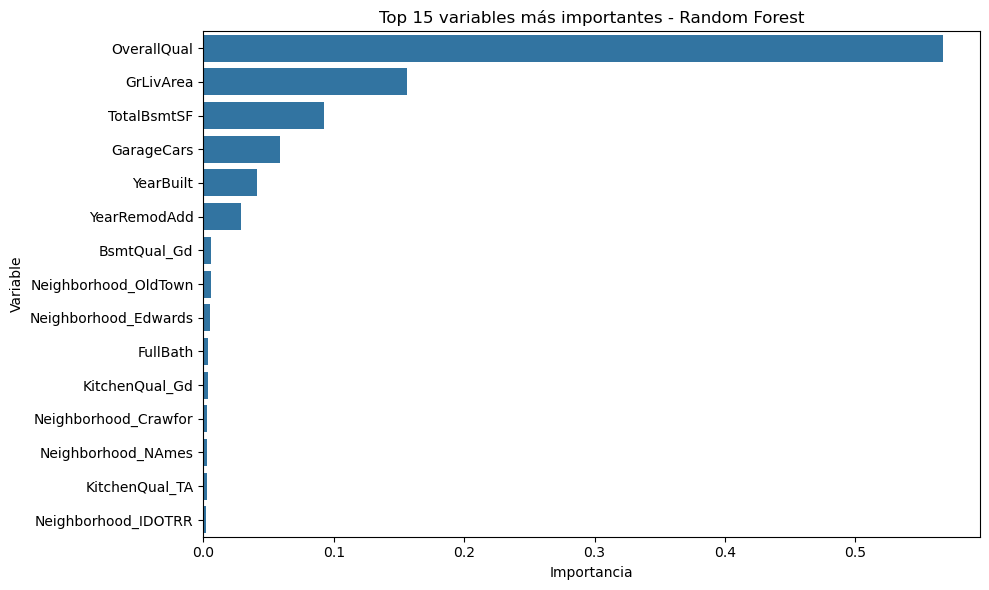

In [33]:
# Importancia de variables en el Random Forest
import matplotlib.pyplot as plt
import seaborn as sns

# Extraer importancias
importances = rf.feature_importances_
feature_names = X_full.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Mostrar las top 15
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.head(15), y=feat_imp.head(15).index)
plt.title('Top 15 variables más importantes - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


### Modelo Random Forest V2 – con más variables predictivas 

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ✅ 1. Variables numéricas (originales + nuevas)
num_features_v2 = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'TotRmsAbvGrd'
]

# ✅ 2. Variables categóricas (originales + nuevas)
cat_features_v2 = [
    'Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual',
    'GarageFinish', 'BsmtExposure', 'BsmtFinType1'
]

# 🧱 3. Codificamos las categóricas con One-Hot Encoding
X_cat_v2 = pd.get_dummies(train_df[cat_features_v2], drop_first=True)

# 🔀 4. Concatenamos numéricas + categóricas
X_v2 = pd.concat([train_df[num_features_v2], X_cat_v2], axis=1)
y_v2 = train_df['LogSalePrice']

# ✂️ 5. División en train y validación
X_train_v2, X_val_v2, y_train_v2, y_val_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

# 🌲 6. Entrenamos modelo Random Forest v2
rf_v2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_v2.fit(X_train_v2, y_train_v2)

# 📈 7. Predicciones y evaluación
y_pred_v2 = rf_v2.predict(X_val_v2)

rmse_log_v2 = np.sqrt(mean_squared_error(y_val_v2, y_pred_v2))
rmse_real_v2 = np.sqrt(mean_squared_error(np.expm1(y_val_v2), np.expm1(y_pred_v2)))

print(f'RMSE (log) RF v2: {rmse_log_v2:.4f}')
print(f'RMSE (escala real) RF v2: {rmse_real_v2:.2f} dólares')


RMSE (log) RF v2: 0.1540
RMSE (escala real) RF v2: 27654.16 dólares


### Comparamos con el Modelo XGBoost

In [37]:
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# 1. Usamos las mismas features de la versión RF v2
X = X_v2  # Ya está construido con numéricas + dummies categóricas
y = y_v2  # Target en escala log

# 2. División en train y validación
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Entrenamos el modelo XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)

# 4. Predicciones y evaluación
y_pred_xgb = xgb_model.predict(X_val_xgb)

rmse_log_xgb = np.sqrt(mean_squared_error(y_val_xgb, y_pred_xgb))
rmse_real_xgb = np.sqrt(mean_squared_error(np.expm1(y_val_xgb), np.expm1(y_pred_xgb)))

print(f'RMSE (log) XGBoost: {rmse_log_xgb:.4f}')
print(f'RMSE (escala real) XGBoost: {rmse_real_xgb:.2f} dólares')


RMSE (log) XGBoost: 0.1512
RMSE (escala real) XGBoost: 26295.15 dólares


### 🧪 Tuning de hiperparámetros con RandomizedSearchCV  
Aplicamos `RandomizedSearchCV` para ajustar automáticamente los hiperparámetros de XGBoost y mejorar el rendimiento. Exploramos 20 combinaciones distintas en una búsqueda aleatoria con validación cruzada (CV=3).


In [39]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint

# 1. Definimos el modelo base
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# 2. Espacio de hiperparámetros a explorar
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

# 3. Configuramos la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,  # Número de combinaciones a probar
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 4. Entrenamos sobre el mismo set
random_search.fit(X_train_xgb, y_train_xgb)

# 5. Resultados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# 6. Evaluamos el mejor modelo en el conjunto de validación
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_val_xgb)

rmse_log_best = np.sqrt(mean_squared_error(y_val_xgb, y_pred_best))
rmse_real_best = np.sqrt(mean_squared_error(np.expm1(y_val_xgb), np.expm1(y_pred_best)))

print(f'RMSE (log) XGBoost Tuned: {rmse_log_best:.4f}')
print(f'RMSE (real) XGBoost Tuned: {rmse_real_best:.2f} dólares')


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.6624074561769746, 'learning_rate': 0.041198904067240534, 'max_depth': 5, 'n_estimators': 187, 'subsample': 0.7334834444556088}
RMSE (log) XGBoost Tuned: 0.1446
RMSE (real) XGBoost Tuned: 25605.09 dólares


### 📊 Comparativa final de modelos  
A continuación se muestra una tabla comparativa con los diferentes modelos entrenados y sus errores (en escala logarítmica y real). Esto permite visualizar claramente la evolución del rendimiento del proyecto.


,Modelo,RMSE (log),RMSE (real)
0,XGBoost Tuned,0.1446,25065.0
1,XGBoost,0.1512,26295.0
2,Random Forest v2,0.1540,27654.0
3,Random Forest v1,0.1568,28889.0
4,Regresión Lineal (base),0.1710,31800.0


C:\Users\Adriatletico\AppData\Local\Temp\ipykernel_19692\2387320050.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


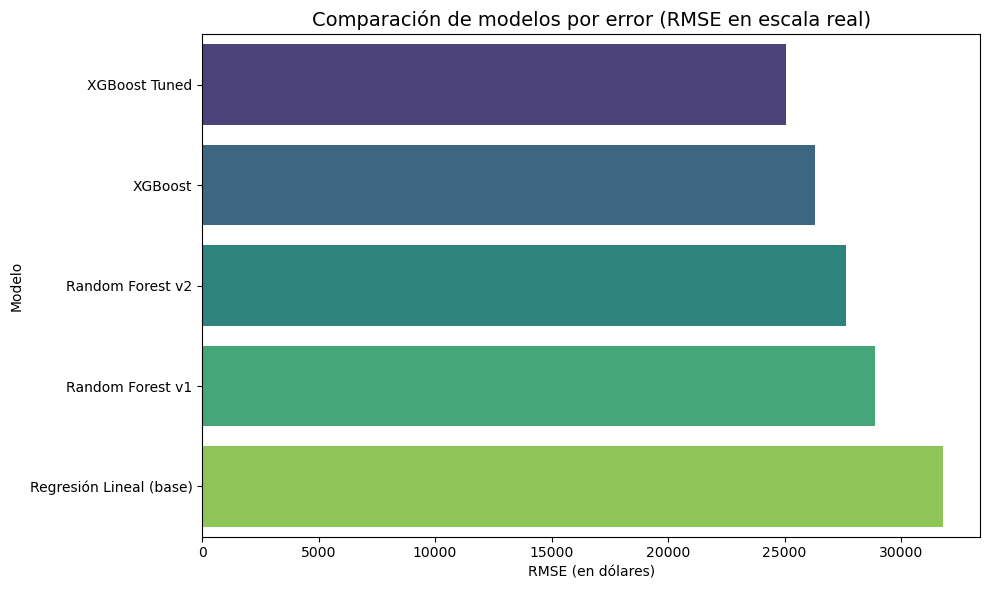

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Resultados
model_results = {
    'Modelo': [
        'Regresión Lineal (base)',
        'Random Forest v1',
        'Random Forest v2',
        'XGBoost',
        'XGBoost Tuned'
    ],
    'RMSE (log)': [
        0.1710,
        0.1568,
        0.1540,
        0.1512,
        0.1446
    ],
    'RMSE (real)': [
        31800.00,
        28889.00,
        27654.00,
        26295.00,
        25065.00
    ]
}

# 2. Creamos el DataFrame
df_resultados = pd.DataFrame(model_results)
df_resultados = df_resultados.sort_values(by='RMSE (real)', ascending=True).reset_index(drop=True)

# 3. Mostramos la tabla
display(df_resultados)

# 4. Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(
    x='RMSE (real)', 
    y='Modelo', 
    data=df_resultados, 
    palette='viridis'
)
plt.title('Comparación de modelos por error (RMSE en escala real)', fontsize=14)
plt.xlabel('RMSE (en dólares)')
plt.ylabel('Modelo')
plt.tight_layout()
plt.show()



In [43]:
import pandas as pd
import numpy as np

# 1. Cargar el test.csv
test_df = pd.read_csv("test.csv")

# 2. Limpieza igual que en train.csv
cols_fill_none = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure',
    'BsmtQual', 'BsmtCond'
]
for col in cols_fill_none:
    test_df[col] = test_df[col].fillna('None')

test_df['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(0)
test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(0)
test_df['LotFrontage'] = test_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_df['Electrical'] = test_df['Electrical'].fillna(test_df['Electrical'].mode()[0])
test_df['KitchenQual'] = test_df['KitchenQual'].fillna('TA')
test_df['Exterior1st'] = test_df['Exterior1st'].fillna(test_df['Exterior1st'].mode()[0])
test_df['Exterior2nd'] = test_df['Exterior2nd'].fillna(test_df['Exterior2nd'].mode()[0])
test_df['SaleType'] = test_df['SaleType'].fillna(test_df['SaleType'].mode()[0])
test_df = test_df.fillna(0)

# 3. Variables del modelo final
num_features_v2 = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'TotRmsAbvGrd'
]
cat_features_v2 = [
    'Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual',
    'GarageFinish', 'BsmtExposure', 'BsmtFinType1'
]

# 4. One-hot encoding de categóricas
X_test_cat = pd.get_dummies(test_df[cat_features_v2], drop_first=True)

# 5. Concatenar numéricas y categóricas
X_test = pd.concat([test_df[num_features_v2], X_test_cat], axis=1)

# 6. Alinear columnas con las usadas por best_model
modelo_cols = best_model.feature_names_in_
missing_cols = set(modelo_cols) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[modelo_cols]  # Reordenamos exactamente igual

# 7. Predecir (en log) y transformar a escala real
y_pred_log = best_model.predict(X_test)
y_pred_real = np.expm1(y_pred_log)

# 8. Crear DataFrame con predicciones y variables clave
test_df_resultado = test_df[['Id', 'OverallQual', 'GrLivArea', 'Neighborhood']].copy()
test_df_resultado['Predicted_Price'] = y_pred_real.round(2)

# 9. Mostrar primeras predicciones
print("Predicciones (primeras 10):")
display(test_df_resultado.head(10))

# 10. Exportar a CSV
test_df_resultado.to_csv('predicciones_test.csv', index=False)



Predicciones (primeras 10):


,Id,OverallQual,GrLivArea,Neighborhood,Predicted_Price
0,1461,5,896,NAmes,119720.507812
1,1462,6,1329,NAmes,138685.140625
2,1463,5,1629,Gilbert,171265.281250
3,1464,6,1604,Gilbert,187469.093750
4,1465,8,1280,StoneBr,194076.156250
5,1466,6,1655,Gilbert,178379.781250
6,1467,6,1187,Gilbert,168825.500000
7,1468,6,1465,Gilbert,170534.453125
8,1469,7,1341,Gilbert,191743.937500
9,1470,4,882,NAmes,117811.242188
